In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import calendar
import datetime
import lightgbm as lgb

In [2]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [3]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
#print many statements at the same time using the below command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress Scientific Notation from Python Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# Reading the datesets 
train_df = pd.read_csv('../input/train_fwYjLYX.csv', parse_dates=['application_date'])
test_df = pd.read_csv('../input/test_1eLl9Yf.csv', parse_dates=['application_date'])
sub = pd.read_csv('../input/sample_submission_IIzFVsf.csv')

In [6]:
# Splitting the data into 2 segments and aggregating them
train_seg1 = train_df[train_df['segment'] == 1]
train_seg1 = train_seg1.groupby('application_date')['case_count'].sum().reset_index()
train_seg2 = train_df[train_df['segment'] == 2]
train_seg2 = train_seg2.groupby('application_date')['case_count'].sum().reset_index()

test_seg1 = test_df[test_df['segment'] == 1]
test_seg2 = test_df[test_df['segment'] == 2]

In [7]:
# Setting the date as index to train and test data frame 
train_seg1['application_date'] = pd.to_datetime(train_seg1['application_date'])
train_seg1.set_index('application_date', drop=False, inplace=True)
train_seg2['application_date'] = pd.to_datetime(train_seg2['application_date'])
train_seg2.set_index('application_date', drop=False, inplace=True)

test_seg1['application_date'] = pd.to_datetime(test_seg1['application_date'])
test_seg1.set_index('application_date', drop=False, inplace=True)
test_seg2['application_date'] = pd.to_datetime(test_seg2['application_date'])
test_seg2.set_index('application_date', drop=False, inplace=True)

In [8]:
# Function to calculate MAPE
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Dealing with Segment 1

In [9]:
train_df = train_seg1
test_df = test_seg1

In [10]:
# Outlier treatment - last row had very less value - Imputed using the same day's count of previous week
train_df.loc['2019-07-05', 'case_count'] = train_df.loc['2019-06-28', 'case_count']

In [11]:
# Since year 2017 had spikes inconsistent with year 2018 and 2019 - removed it for training purpose 
train_df = train_df[train_df['application_date'] >= "2018-01-10"]

In [12]:
holidays_prophet = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(['2018-01-01','2018-01-14','2018-01-26','2018-02-14','2018-03-02','2018-03-18',
    '2018-03-25','2018-03-29','2018-03-30','2018-04-30','2018-05-01','2018-06-16','2018-07-14','2018-08-15',
    '2018-08-22','2018-08-25','2018-08-26','2018-09-03','2018-09-13','2018-09-21','2018-10-02','2018-10-19',
    '2018-11-07','2018-11-21','2018-11-23','2018-12-25','2019-01-01','2019-01-14','2019-01-26','2019-03-04',
    '2019-03-21','2019-04-06','2019-04-13','2019-04-17','2019-04-19','2019-05-01','2019-05-18','2019-06-05',
    '2019-07-04','2019-08-12','2019-08-15','2019-08-24','2019-09-02','2019-09-10','2019-09-11','2019-10-02',
    '2019-10-08','2019-10-27','2019-11-10','2019-11-12','2019-12-25','2017-01-01','2017-01-14','2017-01-26',
    '2017-02-24','2017-03-13','2017-03-28','2017-04-05','2017-04-09','2017-04-14','2017-05-01','2017-05-10',
    '2017-06-25','2017-06-26','2017-08-07','2017-08-14','2017-08-15','2017-08-25','2017-09-02','2017-09-04',
    '2017-09-30','2017-10-01','2017-10-02','2017-10-19','2017-12-01','2017-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

In [13]:
exogenous_features = []
model_fbp = Prophet(yearly_seasonality=True, holidays = holidays_prophet)
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(train_df[["application_date", "case_count"] + exogenous_features].rename(columns={"application_date": "ds", "case_count": "y"}))

forecast = model_fbp.predict(train_df[["application_date"] + exogenous_features].rename(columns={"application_date": "ds"}))
train_df["pred_case_count"] = forecast.yhat.values

forecast = model_fbp.predict(test_df[["application_date"] + exogenous_features].rename(columns={"application_date": "ds"}))
test_df["case_count"] = forecast.yhat.values

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


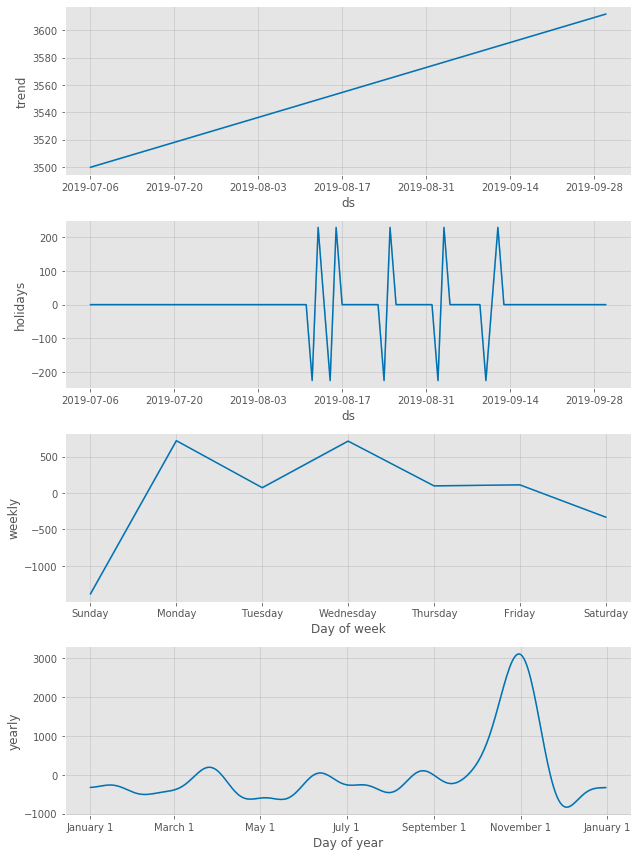

In [14]:
model_fbp.plot_components(forecast);

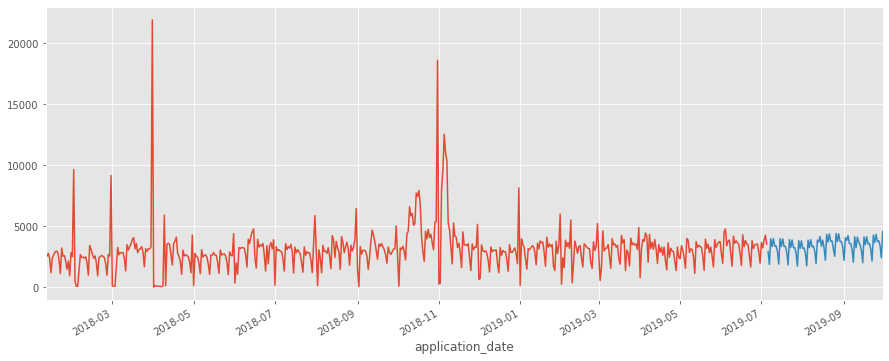

In [15]:
plt.figure(figsize=(15,6))
train_df["case_count"].plot();
test_df["case_count"].plot();

In [16]:
sub_seg1 = test_df[['id', 'application_date', 'segment', 'case_count']]
sub_seg1.reset_index(drop=True, inplace=True)

## Dealing with Segment 2

In [17]:
train_df = train_seg2
test_df = test_seg2

In [18]:
min_date = train_df['application_date'].min()
def extract_dt_features(df):
    df['year'] = df['application_date'].dt.year
    df["month"] = df.application_date.dt.month
    df["week"] = df.application_date.dt.week
    df["day"] = df.application_date.dt.day
    df["day_of_week"] = df.application_date.dt.dayofweek
    df["days_in_month"] = df.application_date.dt.daysinmonth
    df["days_remaining_in_month"] = df['days_in_month'] - df['day']
    df.drop('days_in_month', axis=1,inplace=True)
    df['days_since'] = (df['application_date'] - min_date).dt.days
    return df

train_df = extract_dt_features(train_df)
test_df = extract_dt_features(test_df)

In [19]:
# Week # of the month
def week_of_month(tgtdate):
    
    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we can use the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1

train_df['week_of_month'] = train_df['application_date'].apply(week_of_month)
test_df['week_of_month'] = test_df['application_date'].apply(week_of_month)

In [20]:
train_df['day_lt_10'] = train_df['day'].apply(lambda x: 1 if x<10 else 0)
test_df['day_lt_10'] = train_df['day'].apply(lambda x: 1 if x<10 else 0)

In [21]:
# Adding an indicator for the last day of the month
train_df['month_end'] = train_df['application_date'].apply(lambda x: 1 if x==x+MonthEnd(0)  else 0)
test_df['month_end'] = test_df['application_date'].apply(lambda x: 1 if x==x+MonthEnd(0)  else 0)

In [22]:
holidays = pd.DataFrame({
  'application_date': pd.to_datetime(['2018-01-01','2018-01-14','2018-01-26','2018-02-14','2018-03-02','2018-03-18',
    '2018-03-25','2018-03-29','2018-03-30','2018-04-30','2018-05-01','2018-06-16','2018-07-14','2018-08-15',
    '2018-08-22','2018-08-25','2018-08-26','2018-09-03','2018-09-13','2018-09-21','2018-10-02','2018-10-19',
    '2018-11-07','2018-11-21','2018-11-23','2018-12-25','2019-01-01','2019-01-14','2019-01-26','2019-03-04',
    '2019-03-21','2019-04-06','2019-04-13','2019-04-17','2019-04-19','2019-05-01','2019-05-18','2019-06-05',
    '2019-07-04','2019-08-12','2019-08-15','2019-08-24','2019-09-02','2019-09-10','2019-09-11','2019-10-02',
    '2019-10-08','2019-10-27','2019-11-10','2019-11-12','2019-12-25','2017-01-01','2017-01-14','2017-01-26',
    '2017-02-24','2017-03-13','2017-03-28','2017-04-05','2017-04-09','2017-04-14','2017-05-01','2017-05-10',
    '2017-06-25','2017-06-26','2017-08-07','2017-08-14','2017-08-15','2017-08-25','2017-09-02','2017-09-04',
    '2017-09-30','2017-10-01','2017-10-02','2017-10-19','2017-12-01','2017-12-25']),
    'holiday': 1,
})
train_df.reset_index(drop=True, inplace=True)
train_df.index.rename('Date', inplace=True)
train_df = pd.merge(train_df, holidays, how='left')
train_df.fillna(0, axis=1, inplace=True)
train_df.set_index("application_date", drop=False, inplace=True)

test_df.reset_index(drop=True, inplace=True)
test_df.index.rename('Date', inplace=True)
test_df = pd.merge(test_df, holidays, how='left')
test_df.fillna(0, axis=1, inplace=True)
test_df.set_index("application_date", drop=False, inplace=True)

In [23]:
cols_to_use = ['month', 'week', 'day', 'day_of_week', 'days_remaining_in_month', 'days_since', 'holiday']

In [24]:
params = {}
params["objective"] = "regression"
params['metric'] = 'mape'
params["max_depth"] = 4
params["learning_rate"] = 0.01
params["bagging_fraction"] = 1
params["feature_fraction"] = 1
params["verbosity"] = 500

In [25]:
lgtrain = lgb.Dataset(train_df[cols_to_use], label=train_df['case_count'])
lgb_model_full = lgb.train(params, lgtrain, num_boost_round=2500, verbose_eval=200)

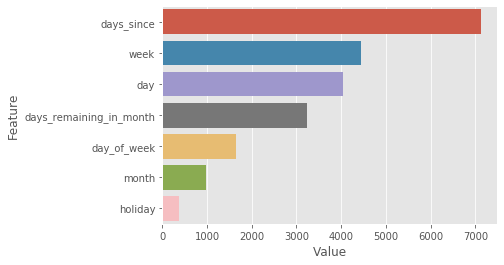

In [26]:
feature_imp = pd.DataFrame(sorted(zip(lgb_model_full.feature_importance(),cols_to_use),reverse=True), columns=['Value','Feature'])
sns.barplot(feature_imp["Value"], feature_imp["Feature"]);

In [27]:
test_df['case_count'] = lgb_model_full.predict(test_df[cols_to_use])

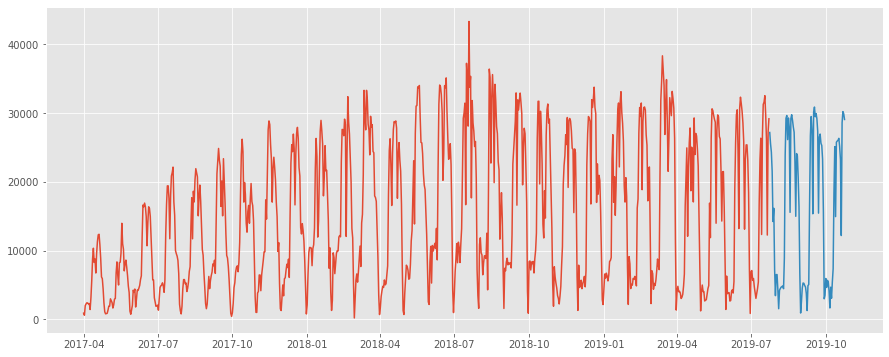

In [28]:
plt.figure(figsize=(15,6))
plt.plot(train_df["case_count"])
plt.plot(test_df["case_count"]);

In [29]:
sub_seg2 = test_df[['id', 'application_date', 'segment', 'case_count']]
sub_seg2.reset_index(drop=True, inplace=True)

In [30]:
sub = pd.concat([sub_seg1, sub_seg2])

In [31]:
sub.to_csv('../submission/final_sub_v2.csv', index=False)